# Processing and analysis of data of raw fltrace traces

## 0. Prerequisites
1. The traces obtained using `fltrace record -M <M_value> -L <L_value> -- program_name`. The parent folder of the traces is designed in the `PARENT_FOLDER_PATH` constant. Inside the parent folder should be several children folders named after benchmark/program traced. Inside each children folder should be grandchildren folders, one per each `(M,L)` pair. Then, inside each grandchildren folder should be the output files of fltrace, that is `fltrace-data-faults*.out`, `fltrace-data-procmaps*.out`, and (optionally) `fltrace-data-stats*.out`. 

    One example hierarchy is 

    ```
    parent/                                   
    ├── canneal/                              
    ┆   ├──200_50/                            
    ┆   ┆   ├──fltrace-data-faults-56090-1.out
    ┆   ┆   ├──fltrace-data-procmaps-56090.out
    ┆   ┆   └──fltrace-data-stats-56090.out   
    ┆   ├──200_100/                           
    ┆   ┆   ├──fltrace-data-faults-55308-1.out
    ┆   ┆   ├──fltrace-data-procmaps-55308.out
    ┆   ┆   └──fltrace-data-stats-55308.out   
    ┆   ├──200_150/                           
    ┆   ┆   ├──...                            
    ┆   └──200_200/                           
    ┆       ├──...                            
    └── fludanimate/                          
        ├──...                                
    ```
    See [the fltrace guide](../data/fltrace.md) to get information about how to get `fltrace` running, as well as how to extend/fix it to get more data. 

2. The objectdumps (`objdump -d /path/to/lib_or_executable_name > lib_or_executable_name`) of all relevant librairies accessed by the traced programs. The folder containing all the objdumps is designed in the `OBJDUMP_FOLDER_PATH` constant. That is, if a library/executable is present in one of the `procmaps` of one of the trace runs, its objdump should be in this directory.

    One example hierarchy is 

    ```
    objdumps/               
    ├── canneal             
    ├── fludanimate         
    ├── fltrace.so          
    ├── ld-linux-x86-64.so.2
    ├── libc.so.6           
    ├── libgcc_s.so.1       
    ├── libm.so.6           
    └── libstdc++.so.6.0.30 
    ```


### Constants & imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import swifter # used even though marked as unused, do not delete 
from utils.fltrace_classes import *
from utils.constants import *
from utils.prepro import *
from plotters import plotter
import matplotlib.pyplot as plt
import functools as ft
import math
from itertools import chain

In [3]:
PARENT_FOLDER_PATH = "../data/parsec_raw_out/"
OBJDUMP_FOLDER_PATH = "../data/objdumps/"

# I. Pre-processing of the trace(s)

First, let us confirm that we have the correct directory tree, as defined in the prerequisites. Let's start by checking that the `objdump` looks correct. Note that we can't do extensive check before reading through the procmaps, which we will do at a later stage.

In [4]:
check_correct_dir(OBJDUMP_FOLDER_PATH)

Then, let's look at the traces data. We take the opportunity of traversing the tree of path to load the relevant data, depending on the value of the `LOAD_DATA` flag.

In [5]:
# choose between "all" to load everything, "" to load nothing, <benchmark_name> to load all runs of one particular benchmark, and parent-relative <path_to/grandchild_directory> if you want to load only one specific run
# for example, LOAD_DATA can therefore be "canneal", or for only one specific run, "canneal/200_50/"
# If there are multiple valid runs in this 200_50 grandchild, only the one with smallest PID will be considered
LOAD_DATA = "fluidanimate"  

In [6]:
check_correct_dir(PARENT_FOLDER_PATH)

#dict of the form: {RunIdentifier : ExtraProcessCodeInfo}
extra_info = defaultdict(ExtraProcessCodeInfo)

#dicts of the form: {RunIdentifier : pandas.DataFrame}
all_dfs = {}
fltrace_impact_stats = {} # df contains (initial_trace_length, number_impacted_ips, idx_first_ip, idx_last_ip, max_num_consecutive)

def check_correct_grandchildren(bench_name: str,path_to_grandchild: Path):
    check_correct_dir_str(path_to_grandchild)
    grand_child_errorstr_prefix = f"Grandchild {path_to_grandchild.absolute().as_posix()}"
    dir_name = path_to_grandchild.name
    assert "_" in dir_name, (grand_child_errorstr_prefix + "does not contain '_' in its name")
    m,l = splitted_name = dir_name.split(sep='_')
    assert len(splitted_name) == 2, (grand_child_errorstr_prefix + "contains more than 1 '_' in its name")
    assert splitted_name[0].isnumeric() and splitted_name[1].isnumeric(), ("The M/L values of "+ grand_child_errorstr_prefix + "are not numbers")
    
    pids_to_procmaps_path = {}
    
    for trace_output in sorted(path_to_grandchild.iterdir(),reverse=True):
        trace_output: Path = trace_output
        assert trace_output.is_file()
        fname = trace_output.stem
        assert len(fname) > 0
        if fname[0] == ".":
            # Ignore hidden files
            continue
        assert fname.startswith(FLTRACE_OUTPUT_PREFIX), f"{trace_output.absolute().as_posix()} is not correctly prefixed"
        assert trace_output.suffix == FLTRACE_OUTPUT_SUFFIX, f"{trace_output.absolute().as_posix()} is not correctly suffixed"
        splitted_fname = fname.split("-")
        pid = int(splitted_fname[-2 if "faults" in fname else -1])
        filetype = splitted_fname[2]
        if filetype == "stats":
            continue
        elif filetype == "procmaps":
            pids_to_procmaps_path[pid] = trace_output
        elif filetype == "faults":
            assert pid in pids_to_procmaps_path.keys(), f"Received faults before procmaps here {trace_output.as_posix()}: are procmaps missing?"
            procmap_path = pids_to_procmaps_path[pid]
            runid = RunIdentifier(bench_name,int(m),int(l),pid)
            if (LOAD_DATA == "all" or 
                    ("/" in LOAD_DATA and (len(all_dfs) == 0 and LOAD_DATA == f"{bench_name}/{m}_{l}")) or
                    ("/" not in LOAD_DATA and LOAD_DATA==bench_name)
                ) :
                df = pd.read_csv(trace_output.as_posix())
                print(f"Loaded data for {runid}. Starting preprocessing.")
                df,fltrace_stats_df,epci = preprocess_df(runid,df, procmap_path)
                print(f"Finished preprocessing data for {runid}.")
                all_dfs[runid] = df
                extra_info[runid] = epci
                fltrace_impact_stats[runid] = fltrace_stats_df
        else:
            raise LookupError(f"While looking at {bench_name}, found the following file in one of the grandchildren which doesn't seem to be the output of fltrace: {trace_output.absolute().as_posix()}")
def check_correct_children(path_to_child: Path):
    check_correct_dir_str(path_to_child)
    benchmark_name = path_to_child.name
    for grandchild in path_to_child.iterdir():
        check_correct_grandchildren(benchmark_name,grandchild)
    print(f"All checks pass for {benchmark_name}.")

In [7]:
for child in Path(PARENT_FOLDER_PATH).iterdir():
    check_correct_children(child)

All checks pass for canneal.
All checks pass for facesim.
All checks pass for bodytrack.
Loaded data for fluidanimate_500_250_72189. Starting preprocessing.
Inspect! fluidanimate_500_250_72189: # of weird ips is 2


Pandas Apply:   0%|          | 0/78510 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78510 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78510 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_250_72189.
Loaded data for fluidanimate_500_500_72968. Starting preprocessing.


Pandas Apply:   0%|          | 0/78455 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78455 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78455 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_500_72968.
Loaded data for fluidanimate_500_375_72575. Starting preprocessing.


Pandas Apply:   0%|          | 0/78456 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78456 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78456 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_375_72575.
Loaded data for fluidanimate_500_100_30887. Starting preprocessing.
Inspect! fluidanimate_500_100_30887: # of weird ips is 2


Pandas Apply:   0%|          | 0/410609 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/410609 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/410609 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/410448 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_100_30887.
Loaded data for fluidanimate_500_125_71795. Starting preprocessing.
Inspect! fluidanimate_500_125_71795: # of weird ips is 2


Pandas Apply:   0%|          | 0/366389 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366389 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366389 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_125_71795.
All checks pass for fluidanimate.
All checks pass for raytrace.
All checks pass for ferret.
All checks pass for dedup.
All checks pass for streamcluster.


In [8]:
assert LOAD_DATA != "", "Cannot analyse the impact of fltrace if no data is loaded!"

For each loaded data, we have the following columns available

In [9]:
', '.join(list(fltrace_impact_stats.values())[0].columns.values)

'initial_trace_length, number_impacted_ips, idx_first_ip, idx_last_ip, max_num_consecutive'

Get the proportion of fltrace ips

In [10]:
all_figs = []
all_groups = []

for runid,rs_df in fltrace_impact_stats.items():
    grouped_count = rs_df.groupby(by="number_impacted_ips").count()['initial_trace_length'].rename('perc_in_stacktrace')
    df = grouped_count.to_frame()
    all_groups.append(df)
    pct_gc = 100*grouped_count/grouped_count.sum()
    fig = plotter.get_pie_bar_zoom_in(pct_gc.to_numpy(),pct_gc.index.to_numpy().astype(str),
                                      fig_title=(r"Percentage of page faults in which $N$ fltrace IPs appear in the stacktrace"+f"\nRun = {runid}"))
    all_figs.append(fig)

In [11]:
#for fig in all_figs: display(fig)

And, aggregated,

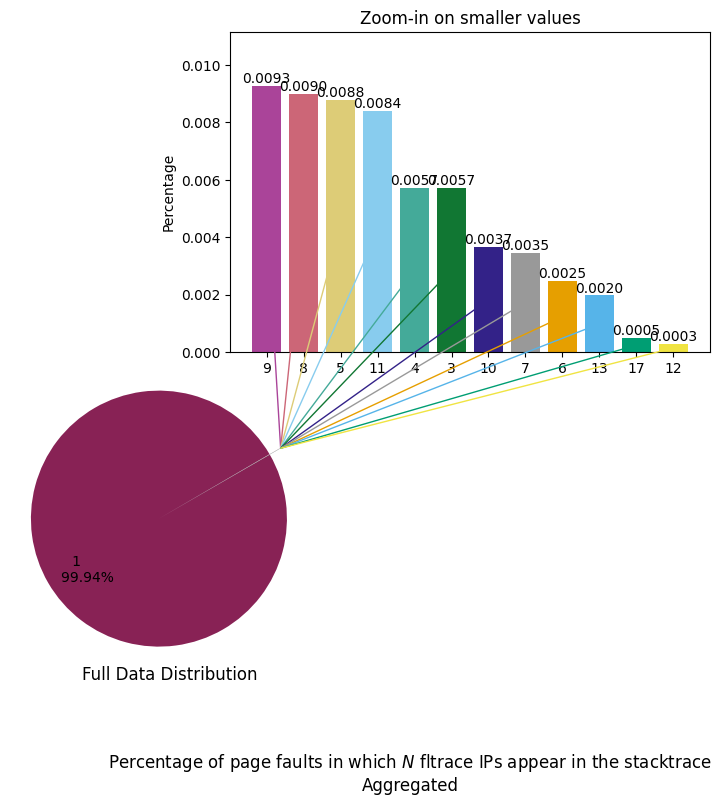

In [12]:
aggregated = pd.concat(all_groups, axis=1, join='outer').fillna(0).sum(axis=1)
aggregated = 100*aggregated/aggregated.sum()
aggregated_fig = plotter.get_pie_bar_zoom_in(aggregated.values,aggregated.index.to_numpy(dtype=str),
                                             fig_title=("Percentage of page faults in which $N$ fltrace IPs appear in the stacktrace"+f"\nAggregated"))
display(aggregated_fig)
plt.close()

It looks like there isn't one data page fault which didn't containt an fltrace IP in its stacktrace!

In [13]:
assert all(len(df[df["number_impacted_ips"] == 0]) == 0 for df in fltrace_impact_stats.values())

Let's look at when on average the first fltrace `ip` appears, grouping by the number of impacted ips

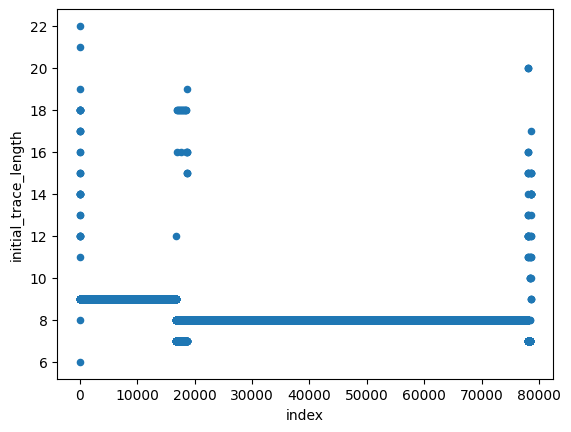

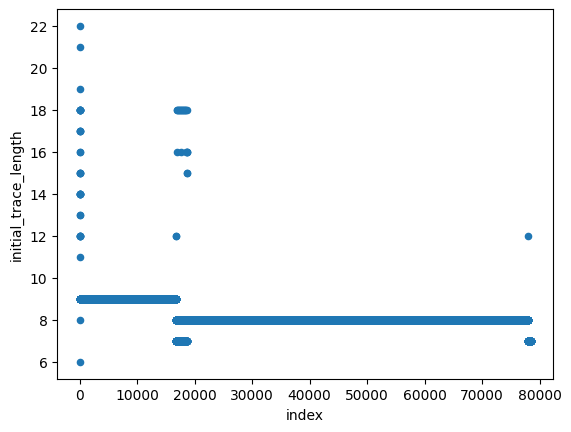

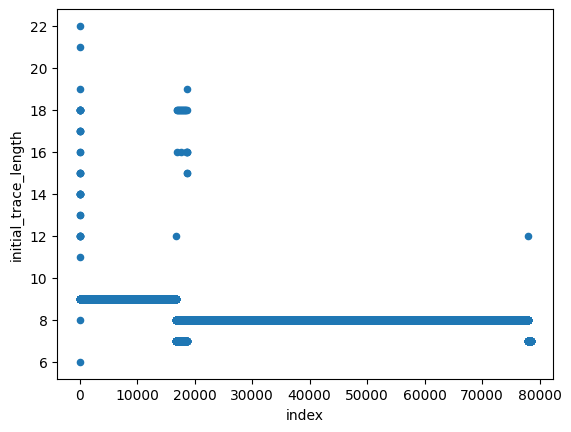

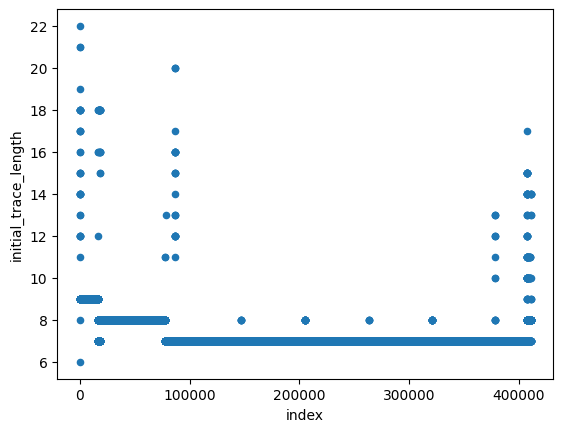

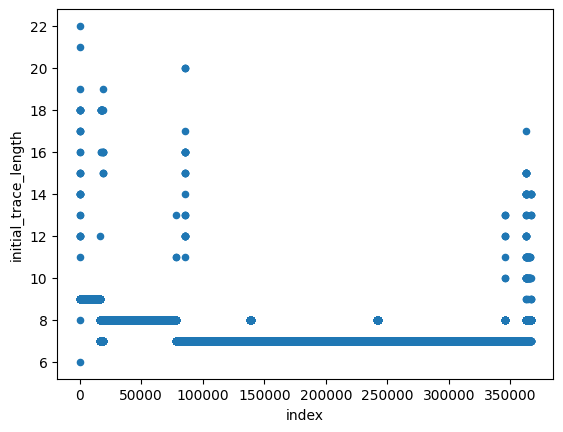

In [14]:
for runid,rs_df in fltrace_impact_stats.items():
    rs_df.reset_index().plot.scatter(x='index',y='initial_trace_length')

Now, let's take a look at the mean position of the ip in the stacktrace.

In [15]:
print("Get stats describing in which position the (faulty) instruction pointer is on average in the stacktrace")
    

for runid,df in all_dfs.items():
    _ ,n_df= get_ip_not_in_st_stats(runid,df)
    all_dfs[runid] = n_df

Get stats describing in which position the (faulty) instruction pointer is on average in the stacktrace
fluidanimate_500_250_72189


Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

There are 21 ips which don't appear in the stacktrace. 
For example, we have 0x7bb8417a0fa0 which is not in its st: 0x7bb841aaa93a|0x7bb8452c947e|0x7bb8452c9568|0x7bb8452e32ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

______________________________
fluidanimate_500_500_72968


Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

There are 8 ips which don't appear in the stacktrace. 
For example, we have 0x734e6f9a0fa0 which is not in its st: 0x734e6fcaa93a|0x734e7354f47e|0x734e7354f568|0x734e735692ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

______________________________
fluidanimate_500_375_72575


Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

There are 8 ips which don't appear in the stacktrace. 
For example, we have 0x723f7c3a0fa0 which is not in its st: 0x723f7c6aa93a|0x723f7fe3847e|0x723f7fe38568|0x723f7fe522ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

______________________________
fluidanimate_500_100_30887


Pandas Apply:   0%|          | 0/410448 [00:00<?, ?it/s]

There are 27 ips which don't appear in the stacktrace. 
For example, we have 0x77578bfa0fa0 which is not in its st: 0x77578c2aa93a|0x77578fa7a47e|0x77578fa7a568|0x77578fa942ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/410448 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/410448 [00:00<?, ?it/s]

______________________________
fluidanimate_500_125_71795


Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

There are 27 ips which don't appear in the stacktrace. 
For example, we have 0x7047c0da0fa0 which is not in its st: 0x7047c10aa93a|0x7047c489347e|0x7047c4893568|0x7047c48ad2ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

______________________________


# II. Data analysis

Let's start by building the connection DAG, where a vertex is a position in code (instruction pointer) and an edge depicts an IP calling a different IP. That is, all sink vertices are instruction pointers causing a page fault.

In [16]:
from utils.graphs import get_connection_graph, get_sink_source_stats

In [17]:
analysis_run_id,analysis_df = list(all_dfs.items())[4]
print(analysis_run_id)
analysis_df["ip_as_int"] = analysis_df["ip"].swifter.apply(lambda ip_str: int(ip_str,16))

fluidanimate_500_125_71795


Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

In [18]:
# for runid,df in all_dfs.items():
#     runid: RunIdentifier
#     connection_graph = get_connection_graph(runid,df)
    #assert nx.is_directed_acyclic_graph(connection_graph)
connection_graph = get_connection_graph(analysis_df,extra_info[analysis_run_id],analysis_run_id)

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

In [19]:
connection_graph.number_of_edges()

123

In [20]:
get_sink_source_stats(connection_graph,analysis_df.stacktrace.unique())

There are 5 paths which are never taken by the trace (no stacktrace goes through them). This is because there exist nodes with more than one outgoing edge, which then connect to other nodes with more than one outgoing edge. 
e.g.: n1 -> A -> n2 -> C  ;  yet n1->B->n2->C is never taken, but it is tehcnically a valid path
         |->B -> n2 -> D
There are 56 sinks and 65 stacktraces.


## Adding back the time dimension - per-path grouping 

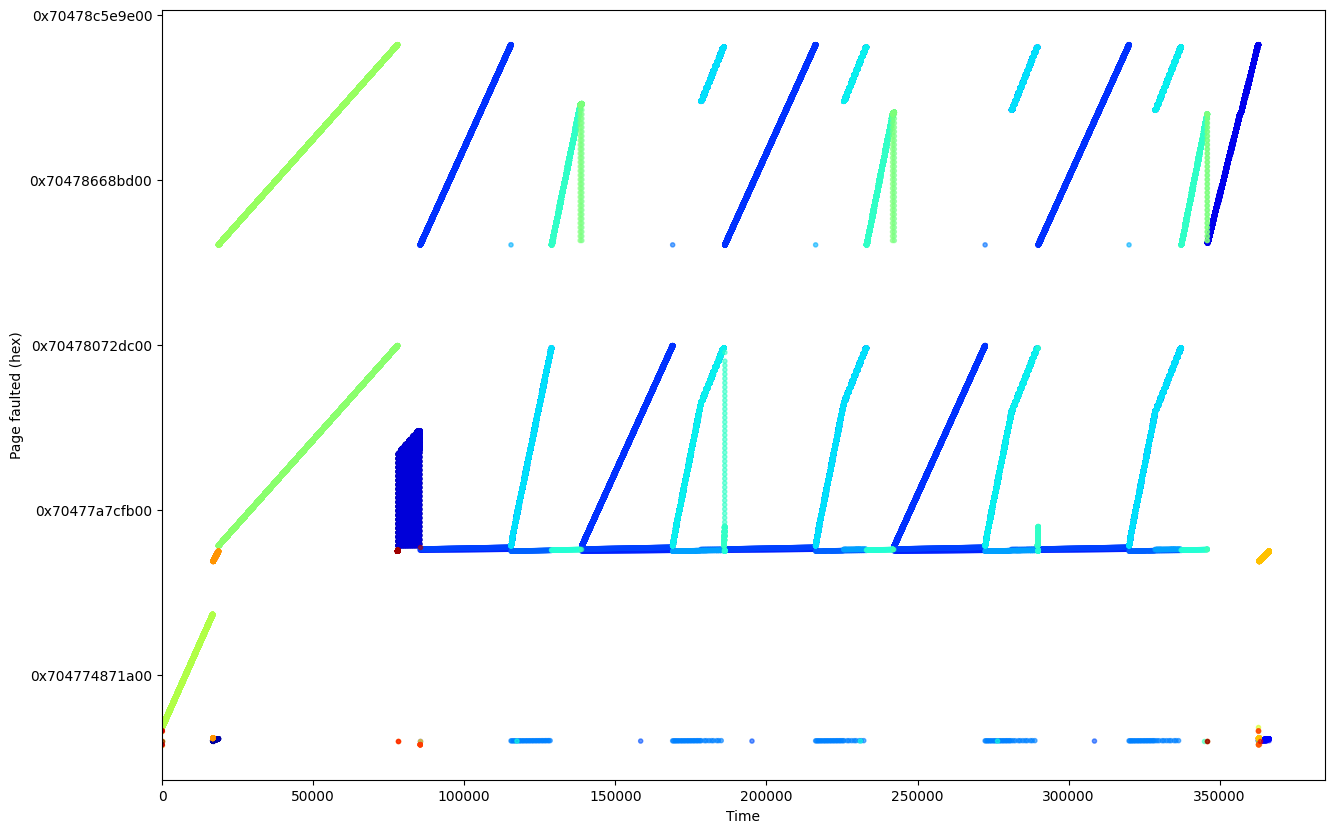

In [21]:

start_point = analysis_df["tstamp"].min()
analysis_df["relative_tstamp"] = analysis_df["tstamp"].apply(lambda t: t-start_point)


grouped_addresses = pd.concat([analysis_df.groupby("stacktrace")["addr"].apply(list).rename("pages").apply(lambda addr_list: [int(addr,16) & ~(PAGE_SIZE-1)  for addr in addr_list]),analysis_df.groupby("stacktrace").size().rename("num_occurrences"),analysis_df.reset_index().groupby("stacktrace")["index"].apply(list).rename("index_occurrences")],axis=1).reset_index()


plt.ioff()
fig,axs,color_dict = plotter.get_time_graph(grouped_addresses)
plt.ion()
display(fig)

Out of the 366232 page faults, 78407 are mandatory faults (cold misses).
Removing them leads us with 48 (down from 65) unique paths taken by the application.


Pandas Apply:   0%|          | 0/48 [00:00<?, ?it/s]

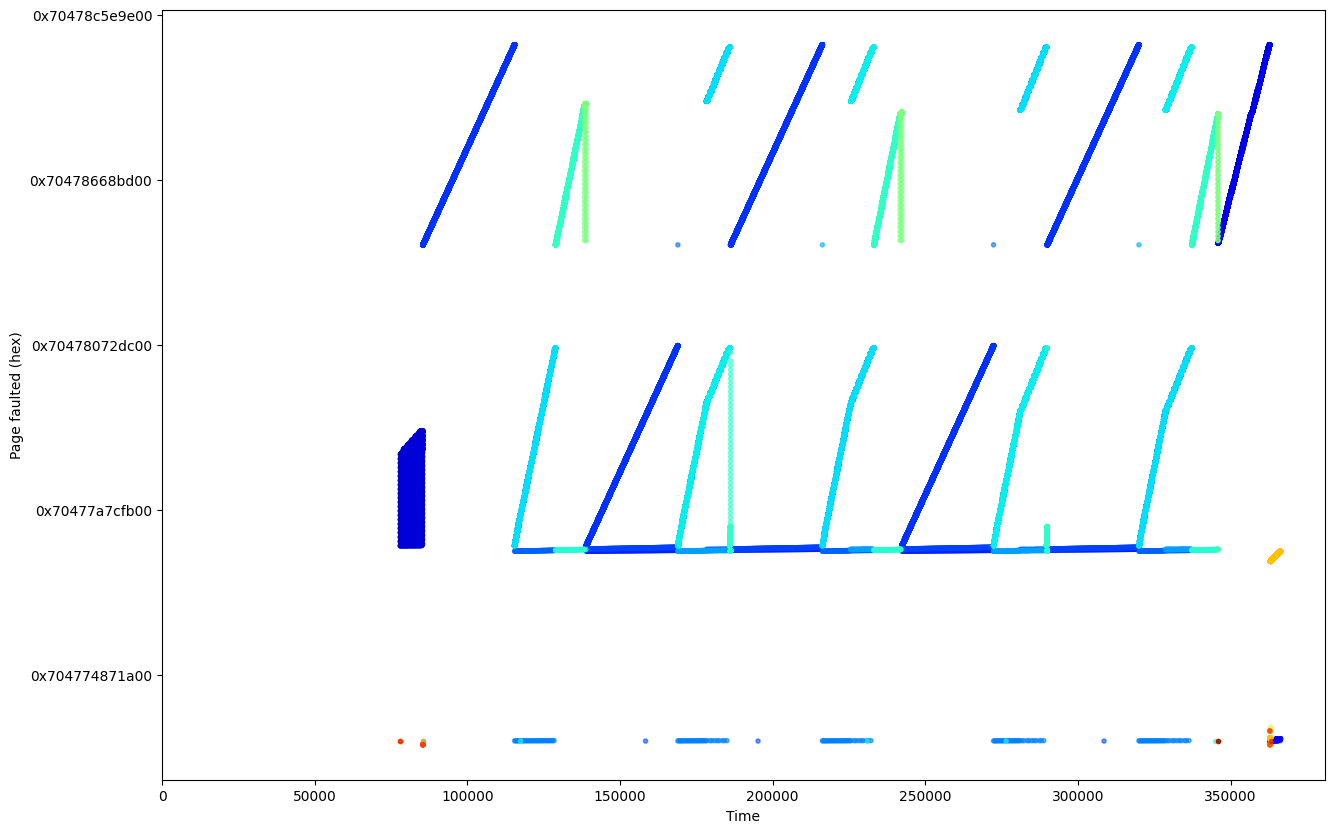

In [22]:
# Exclude the mandatory page faults:
analysis_without_mandatory,_ = get_df_no_cold_miss(analysis_df)
grouped_no_mandatory = get_tl_well_formatted(analysis_without_mandatory)
plt.ioff()
fig,ax,_ = plotter.get_time_graph(grouped_no_mandatory,color_dict)
plt.ion()
display(fig)


In [23]:
mask_interesting = pd.concat([grouped_no_mandatory,grouped_no_mandatory["stacktrace"].apply(lambda st: st.split('|')[0]).rename("ip")],axis=1)
#mask_interesting["ip"].sort_values()

mask_interesting[mask_interesting["ip"] == "0x7047c0c98ec1"][["pages","index_occurrences"]].apply(lambda row: (row.index_occurrences[:3],','.join([hex(page) for page in row.pages])),axis=1)



40    ([362863, 362881, 362884], 0x704772008000,0x70...
41    ([362841, 362847], 0x704772805000,0x704772807000)
42    ([85433, 85435, 85437], 0x704772008000,0x70477...
dtype: object

# III. Registers

In [24]:
test = analysis_df.groupby(by="stacktrace",as_index=True)[["regs","relative_tstamp"]].apply(lambda r: list(zip(r["regs"],r["relative_tstamp"])))

In [25]:
test.head()

stacktrace
0x62e728bdd0ec|0x62e728be1d1b|0x7047c0c29d90|0x7047c0c29e40|0x62e728bdc565    [(123453542527040!108744960535632!108744960514...
0x62e728bdd2d0|0x62e728be1d1b|0x7047c0c29d90|0x7047c0c29e40|0x62e728bdc565    [(123453542527040!108744960535632!108744960514...
0x62e728bdd6b1|0x62e728be1d1b|0x7047c0c29d90|0x7047c0c29e40|0x62e728bdc565    [(123453542527040!108744960535632!108744960514...
0x62e728bdddd1|0x62e728be1d1b|0x7047c0c29d90|0x7047c0c29e40|0x62e728bdc565    [(123453542527040!108744960535632!108744960514...
0x62e728bdde63|0x62e728be1d1b|0x7047c0c29d90|0x7047c0c29e40|0x62e728bdc565    [(123453542527040!108744960535632!108744960514...
dtype: object

In [26]:
R_LEN = 21
R_NAMES = ["r15","r14","r13","r12","rbp","rbx","r11","r10","r9","r8","rax","rcx","rdx","rsi","rdi","orig_rax","rip","cs","eflags","rsp","ss"]

In [27]:
(analysis_df.groupby(by="stacktrace",as_index=False).apply(print))

             tstamp            ip          addr  flags  \
16762  1.728159e+09  62e728bdd0ec  70477221e000     33   

                                                    regs  \
16762  123453542527040!108744960535632!10874496051495...   

                                              stacktrace        ip_as_int  \
16762  0x62e728bdd0ec|0x62e728be1d1b|0x7047c0c29d90|0...  108744960495852   

       relative_tstamp  
16762         0.165571  
             tstamp            ip          addr  flags  \
16763  1.728159e+09  62e728bdd2d0  70477223d000     33   
16764  1.728159e+09  62e728bdd2d0  70477223e000     33   
16765  1.728159e+09  62e728bdd2d0  70477223f000     33   
16766  1.728159e+09  62e728bdd2d0  704772240000     33   
16767  1.728159e+09  62e728bdd2d0  704772241000     33   
16768  1.728159e+09  62e728bdd2d0  704772242000     33   
16769  1.728159e+09  62e728bdd2d0  704772243000     33   
16770  1.728159e+09  62e728bdd2d0  704772244000     33   
16771  1.728159e+09  62e728bdd2d0  

/tmp/ipykernel_917711/3060671226.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (analysis_df.groupby(by="stacktrace",as_index=False).apply(print))


""


In [28]:
gb = analysis_df.copy().reset_index()
gb["regs"] = gb["regs"].swifter.apply(lambda reg_str: np.array([int(x) for x in reg_str.split('!') if x != '']))
gb = gb.groupby(by="stacktrace")

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

In [29]:
from tqdm import tqdm
def get_regs_graphs(gb,color_dict):
    def create_axes(n_plots, max_cols=4):
        n_rows = math.ceil(n_plots / max_cols)
        fig = plt.figure(figsize=(15, 3*n_rows))
        axes = []
        
        for i in range(n_plots):
            row = i // max_cols
            col = i % max_cols
            ax = plt.subplot2grid((n_rows, max_cols), (row, col))
            ax.set_title(f"Register ${R_NAMES[i]}$")
            axes.append(ax)
        
        plt.tight_layout()
        return fig, axes

    fig,axs = create_axes(R_LEN,max_cols=4)

    def populate_graph(gname,regs_np,tsts):
        for reg_i in range(R_LEN):
            reg_ax = axs[reg_i]
            data = regs_np[:,reg_i]
            reg_ax.scatter(tsts,data,color=([color_dict[gname]]*len(data)),alpha=0.6,label=gname,marker='.')

    for group in tqdm(gb.stacktrace.unique(),total=len(gb.stacktrace.unique())):
        grouped_df = gb.get_group(group[0])
        regs_np = np.stack(grouped_df["regs"].values)
        tsts_np = np.stack(grouped_df["relative_tstamp"].values)
        populate_graph(group[0],regs_np,tsts_np)
    return fig,axs

100%|██████████| 65/65 [02:35<00:00,  2.40s/it]


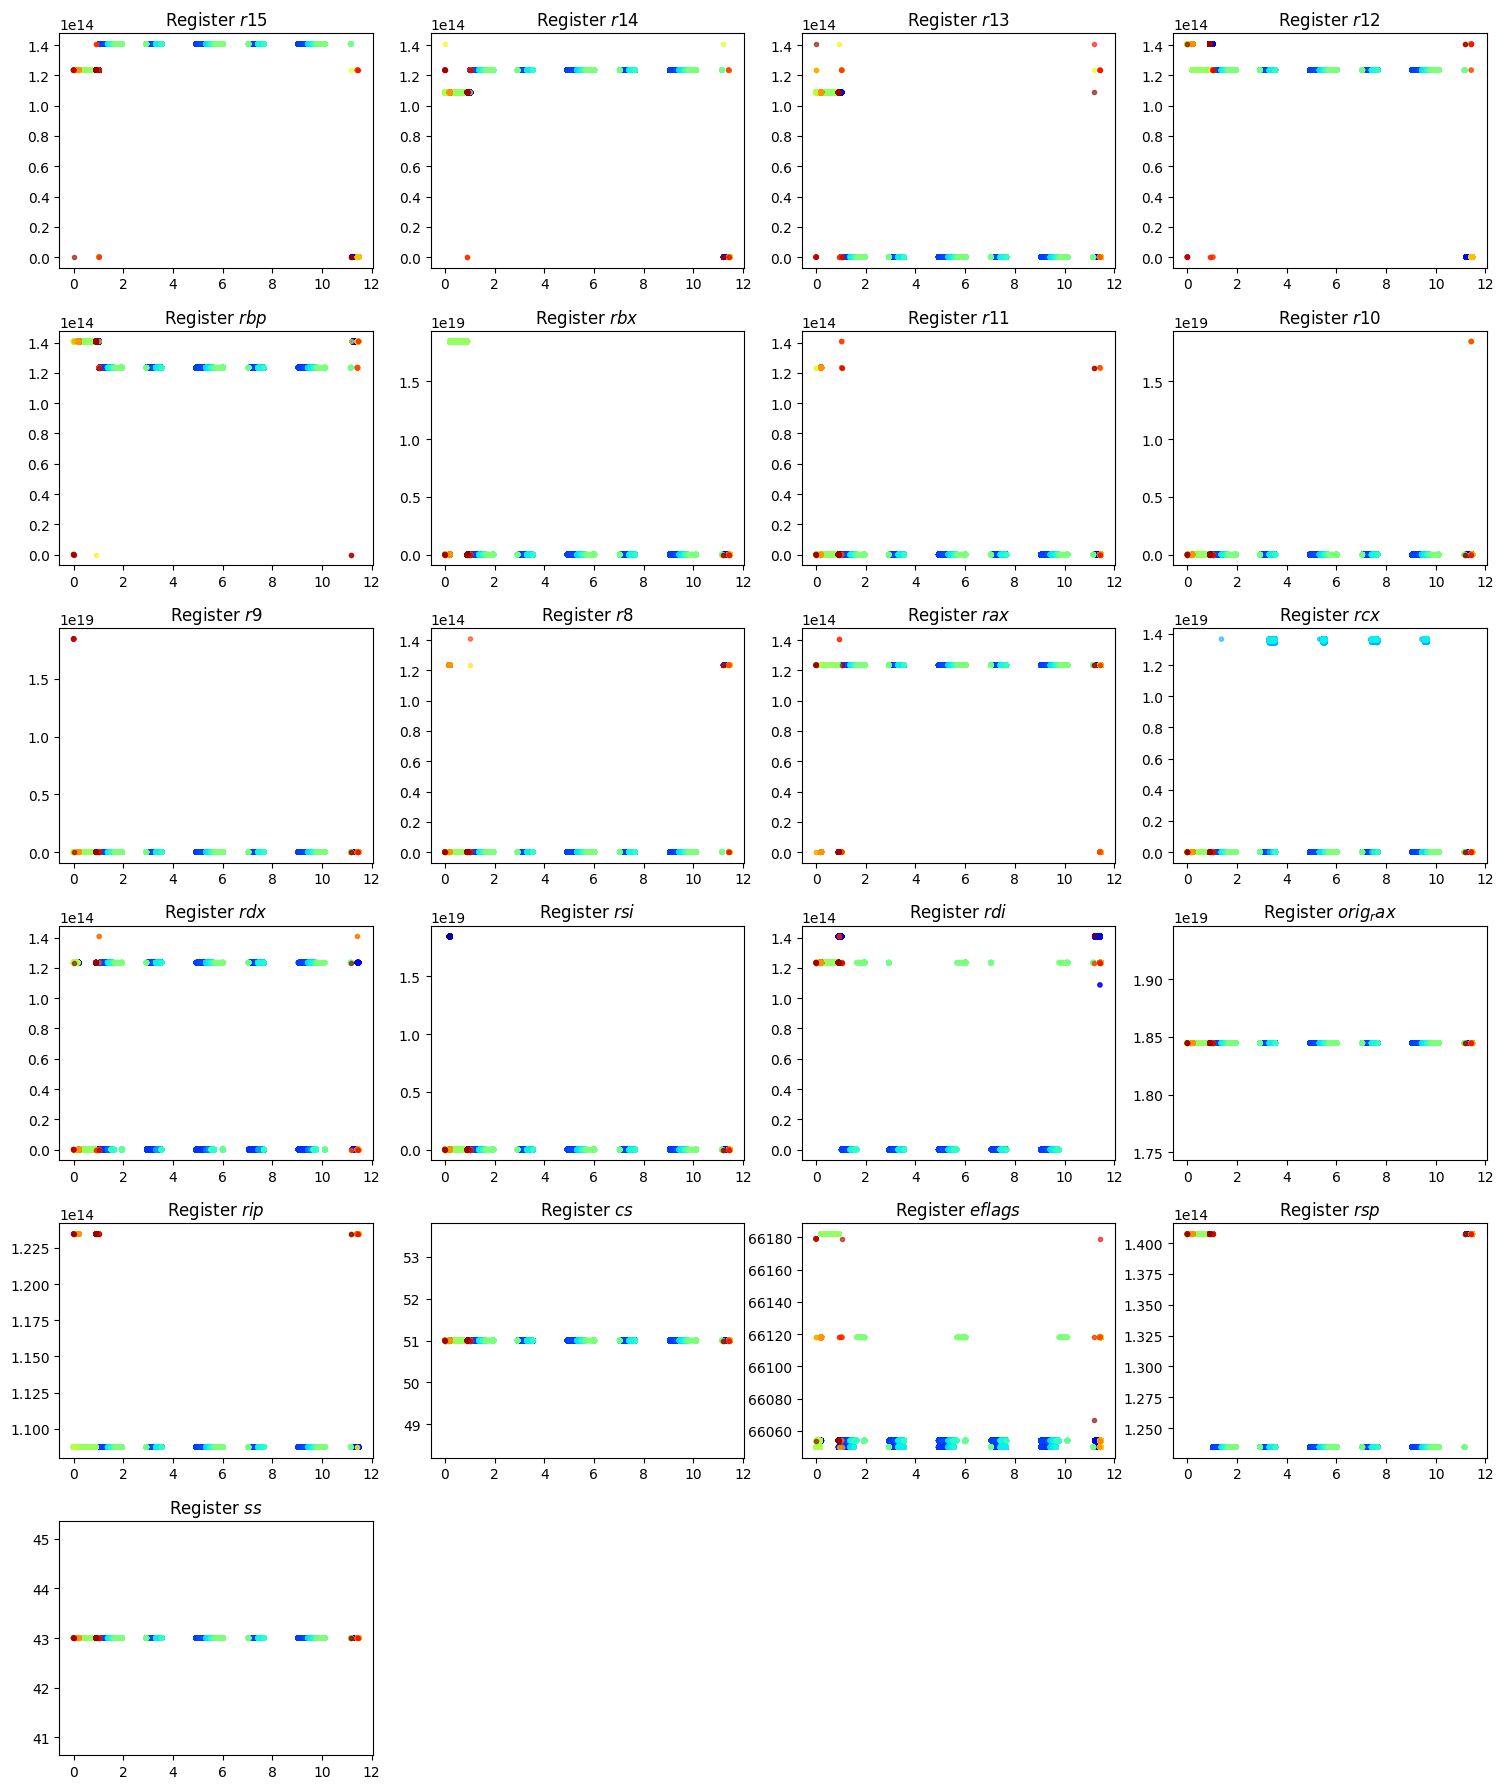

In [30]:
plt.close()
plt.ioff()
f,ax = get_regs_graphs(gb,color_dict=color_dict)
plt.ion()
display(f)
plt.close()

In [31]:
all_regs_data = None
idx_to_color = np.zeros((len(analysis_df),len(list(color_dict.values())[0])))
for group in gb.stacktrace.unique():
    group_name = group[0]
    grouped_df = gb.get_group(group[0])
    group_vals = np.stack(grouped_df["regs"].values)
    if all_regs_data is None:
        all_regs_data = group_vals
    else:
        all_regs_data = np.vstack((all_regs_data,group_vals))
    idx_to_color[grouped_df.index.values] = color_dict[group_name]
print(all_regs_data.shape)

(366232, 21)


In [32]:
idx_to_color

array([[0.76737968, 0.        , 0.        , 1.        ],
       [0.76737968, 0.        , 0.        , 1.        ],
       [0.76737968, 0.        , 0.        , 1.        ],
       ...,
       [1.        , 0.75599129, 0.        , 1.        ],
       [1.        , 0.8140886 , 0.        , 1.        ],
       [1.        , 0.75599129, 0.        , 1.        ]])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import KMeans
from matplotlib import gridspec
from tqdm import tqdm

def find_K(data, alpha=0.3):
    """Determine K by finding maximum number of values that are at least alpha apart"""
    sorted_unique = np.sort(np.unique(data.round(decimals=2)))
    gaps = np.diff(sorted_unique)
    gap_indices = np.where(gaps >= alpha)[0] + 1
    
    if len(gap_indices) == 0:
        return 1
    
    groups = np.split(sorted_unique, gap_indices)
    return len(groups)

def create_axes(n_regs, Ks, max_cols=4):
    n_rows = math.ceil(n_regs / max_cols)
    fig = plt.figure(figsize=(15, 5*n_rows))
    axes = []
    
    for i in range(n_regs):
        row = i // max_cols
        col = i % max_cols
        K = Ks[i]
        if K > 6:
            raise ValueError("too many clusters") 
        gs = gridspec.GridSpecFromSubplotSpec(K, 1, 
            subplot_spec=gridspec.GridSpec(n_rows, max_cols)[row, col],
            height_ratios=[1]*K, hspace=0.15)
        
        subplot_group = []
        for k in range(K):
            ax = fig.add_subplot(gs[k])
            subplot_group.append(ax)
        axes.append(subplot_group)
    
    plt.tight_layout()
    return fig, axes

def plot_register_data(data_array, custom_Ks=None, alpha=1e8, max_cols=4):
    """
    Plot register data from a 2D numpy array
    
    Parameters:
    data_array : np.ndarray of shape (N, N_REGS)
        Each column is a register's data
    custom_Ks : array-like or None
        Optional array of K values for each register. Must have length N_REGS if provided.
        If None, K values will be automatically detected using find_K.
    alpha : float
        Threshold for determining separate clusters (used only if custom_Ks is None)
    max_cols : int
        Maximum number of columns in the plot grid
    padding : float
        Padding around clusters in the plots
    """
    N, N_REGS = data_array.shape
    
    # Validate custom_Ks if provided
    if custom_Ks is not None:
        custom_Ks = np.array(custom_Ks)
        if len(custom_Ks) != N_REGS:
            raise ValueError(f"custom_Ks must have length {N_REGS}, got {len(custom_Ks)}")
        if not np.all(custom_Ks > 0):
            raise ValueError("All K values must be positive")
        if not np.all(np.issubdtype(custom_Ks.dtype, np.integer)):
            raise ValueError("All K values must be integers")
        Ks = custom_Ks
    else:
        # Find K for each register using automatic detection
        Ks = [find_K(data_array[:, i], alpha) for i in range(N_REGS)]
    
    print(f"Using K values: {Ks}")
    
    # Create axes
    fig, axes_groups = create_axes(N_REGS, Ks, max_cols)
    
    # Plot each register
    for reg_idx in tqdm(range(N_REGS), total=N_REGS):
        axes_group = axes_groups[reg_idx]
        data = data_array[:, reg_idx]
        K = Ks[reg_idx]
        
        if K == 1:
            ax = axes_group[0]
            ax.scatter(np.arange(N), data, alpha=0.6,marker=',',color=idx_to_color)
            ax.set_title(f'Register {R_NAMES[reg_idx]} (K=1)')
            continue
            
        x = np.arange(N)
        y = data
        
        # Perform clustering
        kmeans = KMeans(n_clusters=K, random_state=42)
        clusters = kmeans.fit_predict(y.reshape(-1, 1))
        centers = kmeans.cluster_centers_.flatten()

        cond = ((y<1e12) & (clusters != np.argmin(centers)))
        print(f"Points with y<1e12 not associated with the cluster of smallest center: {x[cond]}," 
        +f"associated to clusters # {clusters[cond]}," 
        +f"with center {centers[clusters[cond]]}")

        print(y[341265:341267],clusters[341265:341267],centers[clusters[341265:341267]])


        # Sort clusters by center values
        sorted_centers_idx = np.argsort(centers)[::-1]
        print(sorted_centers_idx)
        centers = centers[sorted_centers_idx]

        
        # Create mapping from original cluster labels to sorted labels
        cluster_map = {old: new for new, old in enumerate(sorted_centers_idx)}
        sorted_clusters = np.array([cluster_map[c] for c in clusters])
        

        # Plot each cluster
        total_sum = 0
        for ax_idx, ax in tqdm(enumerate(axes_group), total=len(axes_group), desc="Plotting each cluster"):
            cluster_mask = sorted_clusters == ax_idx
            cluster_points = y[cluster_mask]
            print("Clusters:",cluster_points.min(),cluster_points.max())
            print(TEXT_SEPARATOR)

            cluster_x = x[cluster_mask]
            total_sum += np.sum(cluster_mask)

            if len(cluster_points) > 0:

                y_offset = np.min(cluster_points)
                print(y_offset)
                normalized_points = cluster_points - y_offset
                
                padding = (np.max(normalized_points)) // 10
                print(padding)
                y_min = 0 - padding
                y_max = np.max(normalized_points) + padding

                ax.clear()
                ax.autoscale(enable=False)

                pc = ax.scatter(cluster_x, normalized_points, alpha=0.6,marker=',',color=idx_to_color[cluster_mask],zorder=2)
            
                ax.set_ylim(y_min, y_max)
                ax.set_xlim(np.min(x), np.max(x) + np.max(x)//100)

                def format_func(y, pos):
                    return f'{y + y_offset:.4E}'
                
                ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
        
        
            # Debug after scatter
            print(f"After scatter - ylim: {ax.get_ylim()}")
            print(f"DataLim: {ax.dataLim.bounds}")
            print(f"ViewLim: {ax.viewLim.bounds}")
            
            # Add break markers with explicit transform
            if ax_idx != K-1:
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                d = .015
                kwargs = dict(transform=ax.transAxes, color='r', clip_on=False, zorder=10)
                ax.plot((-d, +d), (-d, +d), **kwargs)
                ax.plot((1-d, 1+d), (-d, +d), **kwargs)
                
            if ax_idx != 0:
                ax.spines['top'].set_visible(False)
                d = .015
                kwargs = dict(transform=ax.transAxes, color='r', clip_on=False, zorder=10)
                ax.plot((-d, +d), (1-d, 1+d), **kwargs)
                ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)    

            points = pc.get_offsets()
            print(f"Normalized points y range: {np.min(points[:,1])} to {np.max(points[:,1])}")
            transformed = ax.transData.transform(points)
            print(f"Transformed points y range: {np.min(transformed[:,1])} to {np.max(transformed[:,1])}")
            # Final debug
            print(f"Final ylim: {ax.get_ylim()}\n")

        print(total_sum)
        print(TEXT_SEPARATOR)
        #assert False
        # Labels and title
        axes_group[-1].set_xlabel('Time')
        if K > 2:
            axes_group[K//2].set_ylabel('Value')
        else:
            axes_group[0].set_ylabel('Value')
        axes_group[0].set_title(f'Register {R_NAMES[reg_idx]} (K={K})')
    
    plt.tight_layout()
    return fig, axes_groups

Using K values: [3 3 4 3 3 2 3 2 2 3 3 3 3 2 4 1 2 1 3 2 1]


  0%|          | 0/21 [00:00<?, ?it/s]

Points with y<1e12 not associated with the cluster of smallest center: [],associated to clusters # [],with center []
[1.23453543e+14 1.23453543e+14] [2 2] [1.23453542e+14 1.23453542e+14]
[0 2 1]


Clusters: 140736299713992.0 140736299714528.0
______________________________
140736299713992.0
53.0
After scatter - ylim: (-53.0, 589.0)
DataLim: (24821.0, 0.0, 341266.0, 536.0)
ViewLim: (0.0, -53.0, 369893.0, 642.0)
Normalized points y range: 0.0 to 536.0
Transformed points y range: 2853.482530392188 to 2968.16056725091
Final ylim: (-53.0, 589.0)

Clusters: 123452157593984.0 123453542527040.0
______________________________
123452157593984.0
138493305.0


  0%|          | 0/21 [00:00<?, ?it/s]


After scatter - ylim: (-138493305.0, 1523426361.0)
DataLim: (0.0, 0.0, 366229.0, 1384933056.0)
ViewLim: (0.0, -138493305.0, 369893.0, 1661919666.0)
Normalized points y range: 0.0 to 1384933056.0
Transformed points y range: 2695.6290684210767 to 2810.0931538011455
Final ylim: (-138493305.0, 1523426361.0)

Clusters: 0.0 192.0
______________________________
0.0
19.0
After scatter - ylim: (-19.0, 211.0)
DataLim: (7664.0, 0.0, 358567.0, 192.0)
ViewLim: (0.0, -19.0, 369893.0, 230.0)
Normalized points y range: 0.0 to 192.0
Transformed points y range: 2537.569096764749 to 2652.232250036598
Final ylim: (-19.0, 211.0)

366232
______________________________


AssertionError: 

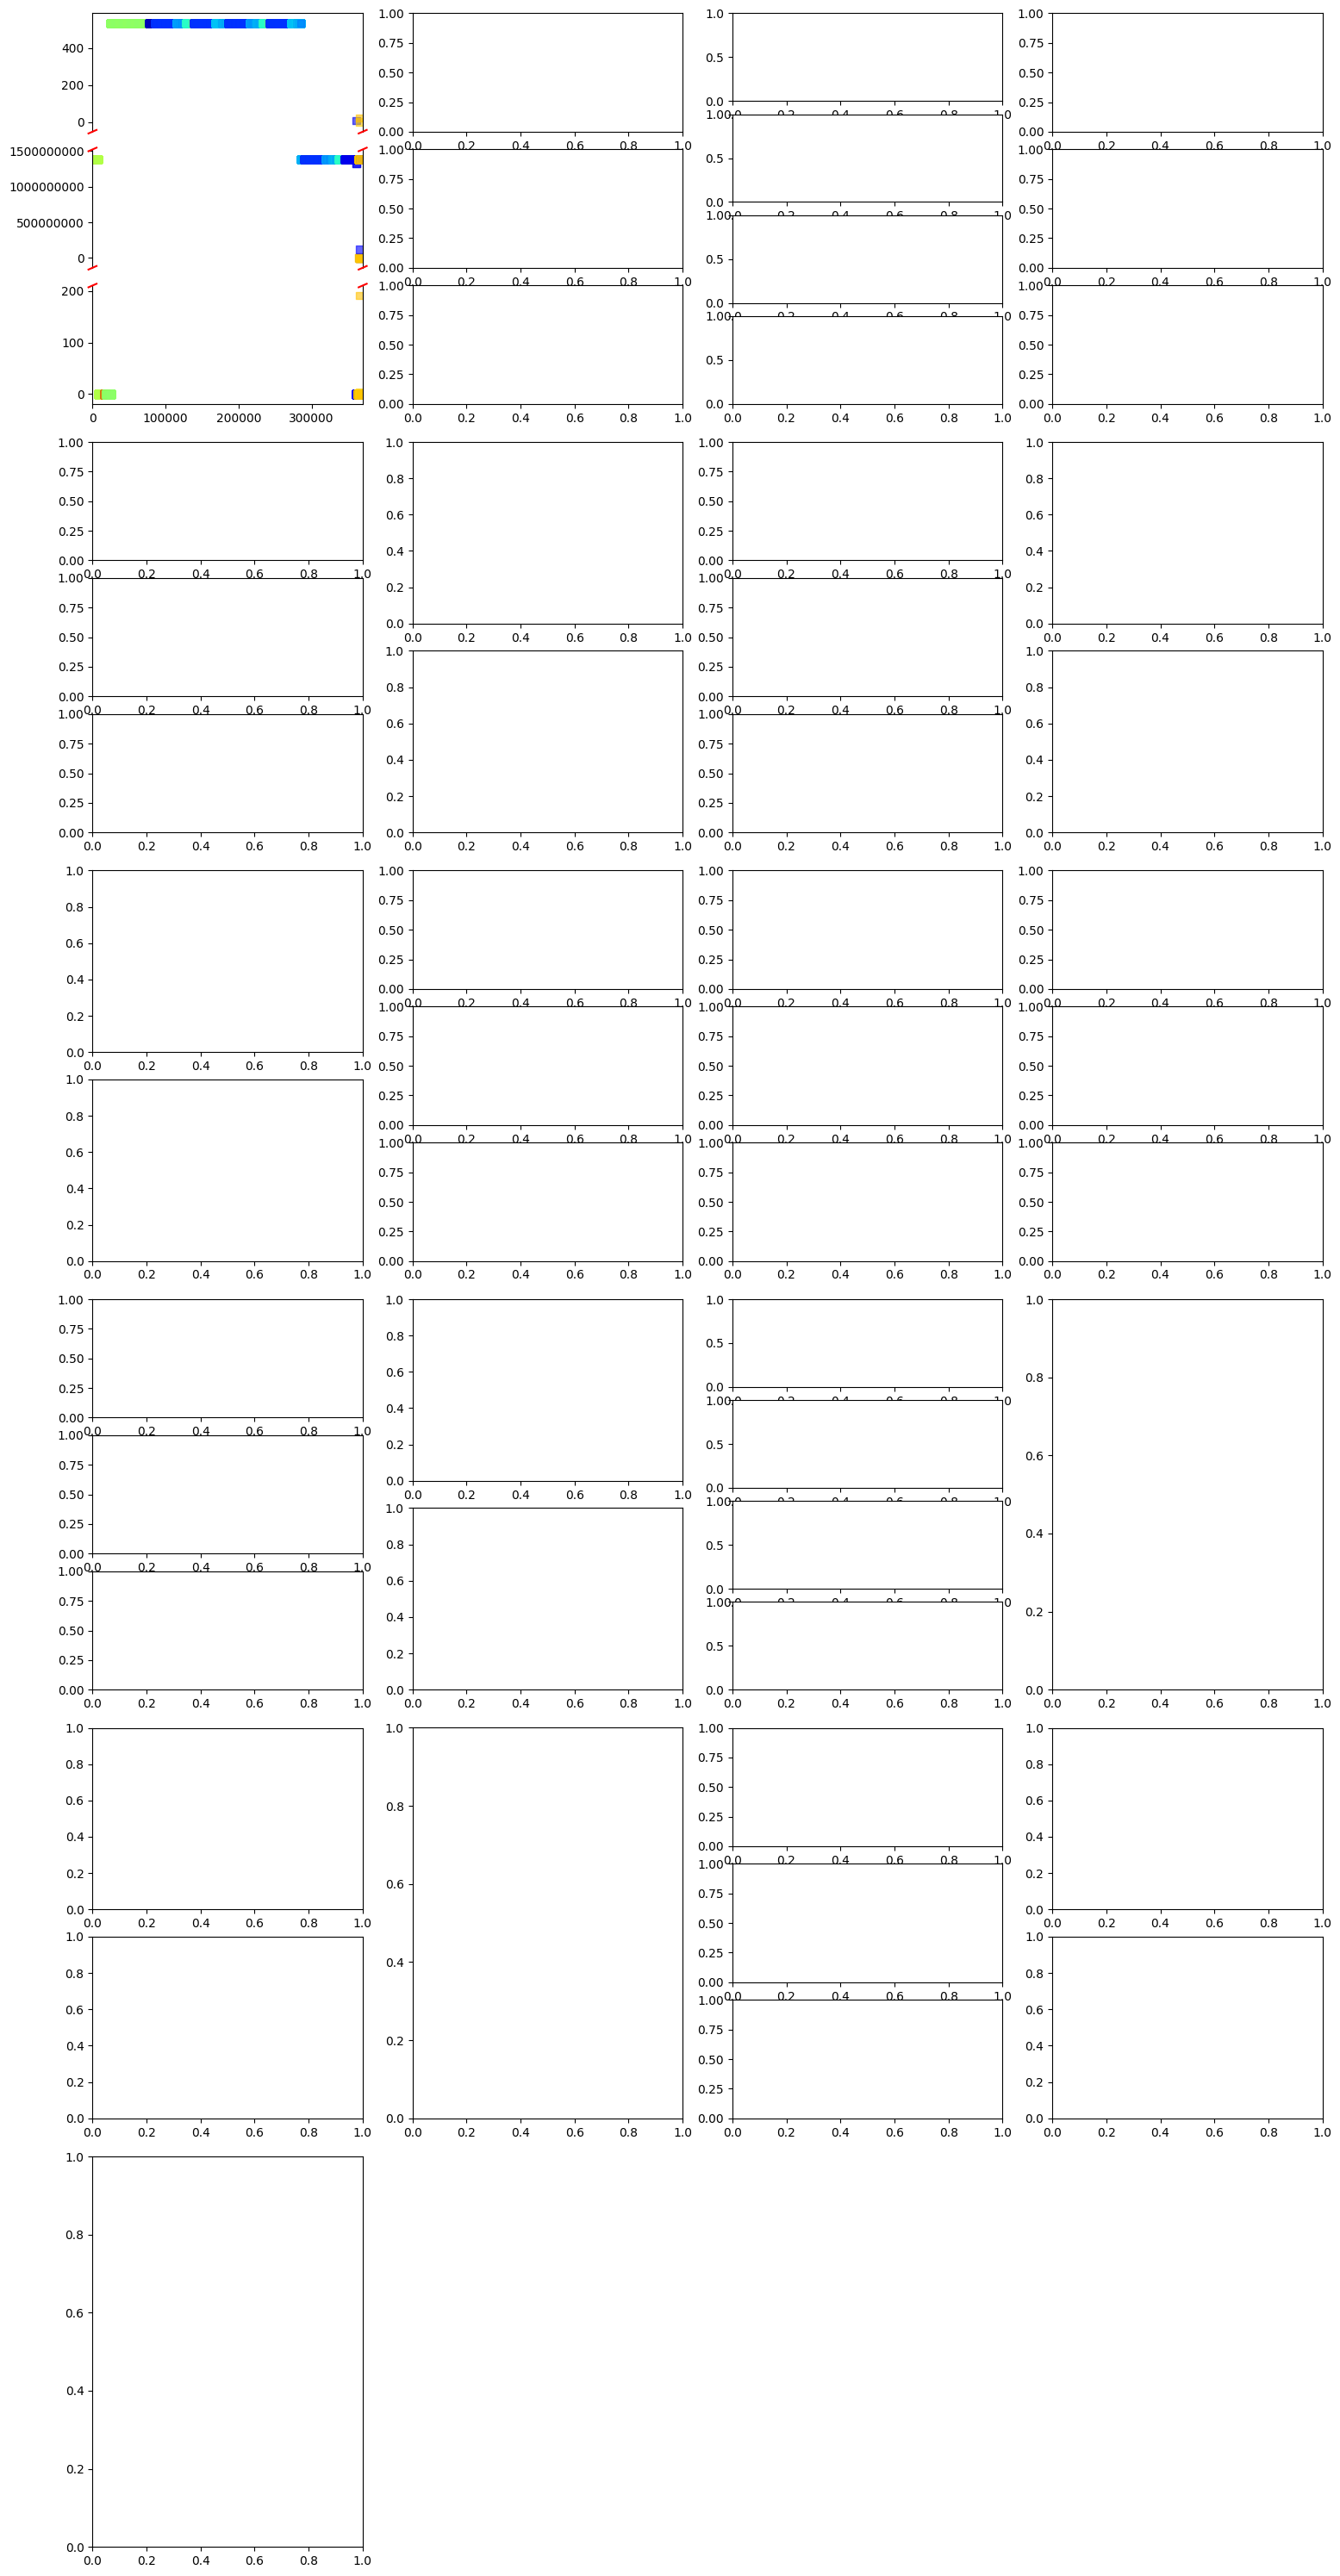

In [ ]:
fig,axg = plot_register_data(all_regs_data,custom_Ks=[3,3,4,3,3,2,3,2,2,3,3,3,3,2,4,1,2,1,3,2,1],alpha=5e14)
fig.savefig("outs/reg_clustered.png")